<a href="https://colab.research.google.com/github/unburied/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [28]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [29]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [30]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=80.965078696773, mobile=True), User(purchased=False, time_on_site=106.63493952332205, mobile=True), User(purchased=False, time_on_site=102.46227868780954, mobile=True), User(purchased=True, time_on_site=39.07309753847065, mobile=True), User(purchased=False, time_on_site=95.18276599008922, mobile=True), User(purchased=True, time_on_site=166.62460199332173, mobile=True), User(purchased=False, time_on_site=245.17851562175034, mobile=True), User(purchased=True, time_on_site=155.30128512941042, mobile=False), User(purchased=False, time_on_site=129.98388742956615, mobile=True), User(purchased=True, time_on_site=53.16190743265933, mobile=True)]


In [31]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,80.965079,True
1,False,106.634940,True
2,False,102.462279,True
3,True,39.073098,True
4,False,95.182766,True


In [32]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.994421454968269,6.293516373720531,6.3506034806861695,6.404962478248474,8.244003107043238,8.488025577286415,8.549150034712088,8.798793657837955,9.028748714585218,9.759266454797856,...,562.029183364062,564.7437721978712,565.8439207740871,579.6107919505648,581.4846828838351,582.7462645013718,584.8354867158619,587.0773481251045,587.2906044855217,588.529773813577
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,0,1,1,0,1,1,1,...,1,0,1,1,0,0,1,0,1,0
True,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,1,1,0,1,0,1


In [33]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

TypeError: ignored

In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
import pandas as pd

In [35]:
df = pd.read_csv('persons.csv')
df.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [36]:
df.dtypes

Unnamed: 0       int64
age              int64
weight           int64
exercise_time    int64
dtype: object

In [37]:
df.drop(labels = 'Unnamed: 0', axis = 1, inplace = True)
df.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


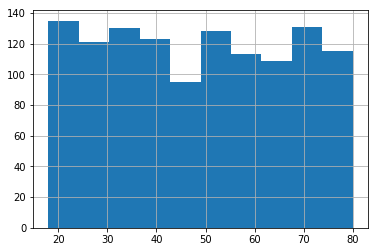

In [38]:
df['age'].hist();

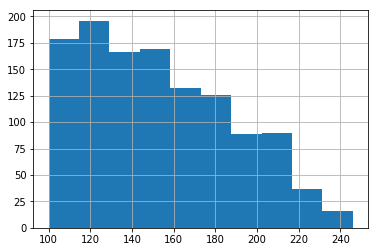

In [39]:
df['weight'].hist();

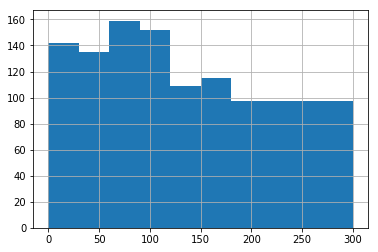

In [40]:
df['exercise_time'].hist();

In [0]:
import matplotlib.pyplot as plt


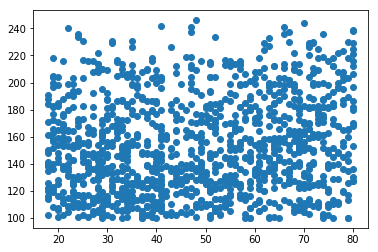

In [42]:
plt.scatter(df['age'], df['weight']);

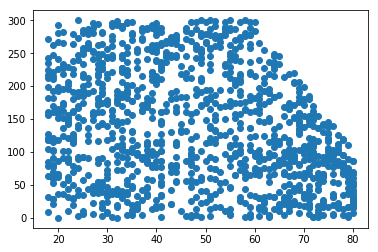

In [43]:
plt.scatter(df['age'], df['exercise_time']);

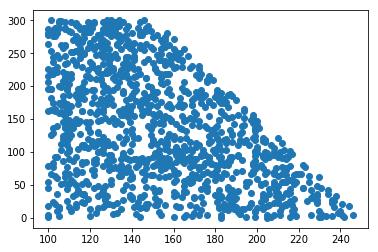

In [44]:
plt.scatter(df['weight'], df['exercise_time']);

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [48]:
train, test = train_test_split(df)
train.shape, test.shape

((900, 3), (300, 3))

In [0]:
from sklearn.metrics import mean_absolute_error

def error():
  y_true = train[target]
  y_pred = model.predict(train[features])
  train_error = mean_absolute_error(y_true, y_pred)
  
  y_true = test[target]
  y_pred = model.predict(test[features])
  test_error = mean_absolute_error(y_true, y_pred)
  
  print('Trained Weight Error: ', round(train_error))
  print('Test Weight Error: ', round(test_error))
  

In [61]:
features = ['exercise_time']
target = 'weight'

model = LinearRegression()
model.fit(train[features], train[target])

error()

Trained Weight Error:  26.0
Test Weight Error:  24.0


In [56]:
df['weight'].describe()

count    1200.000000
mean      153.540833
std        35.132182
min       100.000000
25%       125.000000
50%       149.000000
75%       180.250000
max       246.000000
Name: weight, dtype: float64

In [0]:
b = model.intercept_
m = model.coef_

x = df['exercise_time']
y = m * x + b

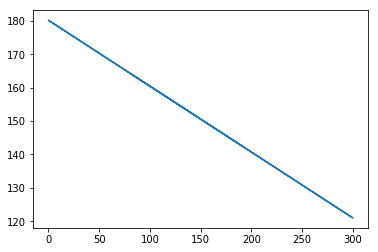

In [63]:
plt.plot(x,y);

### Assignment questions

After you've worked on some code, answer the following questions in this text block:



1.  What are the variable types in the data?

    All of the variables are integers, and couold also be considered semi-continuous
    
    
    
2.  What are the relationships between the variables?



    Weight seems to be a dependant variable here. I used a model to better outline what the relationships entailed. Age and Excercise time appear to be independant, and unrelated to each other. 
    
    
    
3.  Which relationships are "real", and which spurious?


    Age and Excercise can be considered spurious. You cant claim you get older because you exercise more, or vice versa. There would be other factors involved. Time being one. I initially thought there would be a relationship between Age and Weight, but upon closer inspection, there was none. People of all ages can come in all sizes. There 'real' relationship came from Weight and Exercise. As you can see from the model above, the more you exercise, the less you weigh. The model appears to be pretty accurate, with the degree of error being less than one standard deviation of the weight distribution. 

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)